In [1]:
from cloudmesh.common.Shell import Shell
from cloudmesh.common import readfile
import sys
import pandas as pd
import io
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [2]:
def read_energy(filename=None):
   full_filename = Shell.map_filename(filename).path
   # 1: means removing hashes
   content = readfile(full_filename).splitlines()[1:]
   # removing #
   content[0] = content[0][2:]
   # print(content[0:10])
   content = "\n".join(content)
   content = content.replace(', ', ',')
   df = pd.read_csv(io.StringIO(content),sep=',')
   return df


In [3]:
def export_figure(x='Time/s', y='Energy/W', filename=None):
   plt.xlabel(x)
   plt.ylabel(y)
   base = os.path.dirname(filename.replace('_', '-').lower())
   png = base + ".png"
   pdf = base + ".pdf"
   plt.savefig(png, bbox_inches='tight', dpi=600)
   plt.savefig(pdf, bbox_inches='tight')

FileNotFoundError: [Errno 2] No such file or directory: '/home/green/Desktop/github/mlcommons/benchmarks/earthquake/analysis/energy/data/old/card_name_v100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_2/gpu0.log'

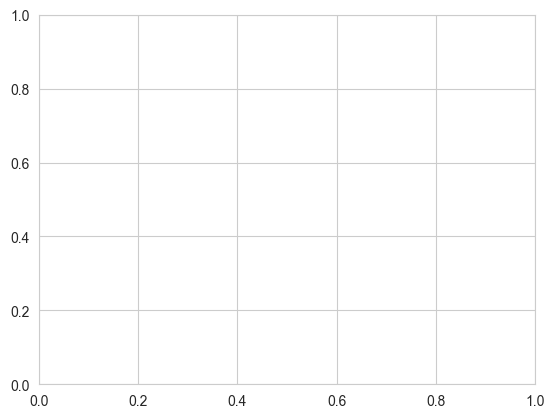

In [4]:
list_of_filenames = [('./data/old/card_name_v100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_2/gpu0.log', 2),
                     ('./data/old/card_name_v100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_30/gpu0.log', 30),
                     ('./data/old/card_name_v100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_70/gpu0.log', 70)]

for filename, epoch in list_of_filenames:
   fig, ax = plt.subplots()
   df = read_energy(filename)
   label = f'Epoch {epoch}'
   df.rename(columns = {'0 power_draw W':label}, inplace=True)
   energy = df[['time', label]]
   sns.lineplot(energy)
   export_figure(filename=filename)
   plt.show()

In [25]:
err_dir_path = Shell.map_filename(
    './data/old/card_name_v100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_2/'
).path
full_dir_path = None

for file in os.listdir(err_dir_path):
   if file.endswith(".err"):
      print(os.path.join(err_dir_path, file))
      full_dir_path = os.path.join(err_dir_path, file)

C:\Users\stapm\cm\mlcommons\benchmarks\earthquake\analysis\energy\data\old\card_name_v100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_2\dje5dj-44848919.err


In [26]:
content = readfile(full_dir_path, encoding='utf-8').splitlines()
# headline = '# csv,timer,status,time,sum,start,tag,msg,uname.node,user,uname.system,platform.version'
headline = Shell.cm_grep(content, '# csv,timer')[0]
csv_lines = Shell.cm_grep(content, '# csv')
csv_lines = Shell.cm_grep(csv_lines, 'Linux')
csv_lines.insert(0, headline)
# print("\n".join(csv_lines))
# content = "\n".join(csv_lines)
content = content.replace(', ', ',')
timer_df = pd.read_csv(io.StringIO(content),sep=',')

# csv,timer,status,time,sum,start,tag,msg,uname.node,user,uname.system,platform.version
# csv,total,failed,None,0.0,2022-11-09 17:05:45,,None,udc-aj36-36,dje5dj,Linux,#1 SMP Wed Feb 23 16:47:03 UTC 2022
# csv,total,ok,13752.481,13752.481,2022-11-09 17:05:45,,None,udc-aj36-36,dje5dj,Linux,#1 SMP Wed Feb 23 16:47:03 UTC 2022
# csv,INIT,ok,0.979,0.979,2022-11-09 17:05:50,,None,udc-aj36-36,dje5dj,Linux,#1 SMP Wed Feb 23 16:47:03 UTC 2022
# csv,EVAL,ok,440.14,440.14,2022-11-09 17:05:51,,None,udc-aj36-36,dje5dj,Linux,#1 SMP Wed Feb 23 16:47:03 UTC 2022
# csv,PLOTS,ok,411.943,411.943,2022-11-09 17:05:52,,None,udc-aj36-36,dje5dj,Linux,#1 SMP Wed Feb 23 16:47:03 UTC 2022
# csv,CELL_READ_DATA,ok,230.647,230.647,2022-11-09 17:05:52,,None,udc-aj36-36,dje5dj,Linux,#1 SMP Wed Feb 23 16:47:03 UTC 2022
# csv,SPACE_FILLING_CURVE,ok,1.075,1.075,2022-11-09 17:05:52,,None,udc-aj36-36,dje5dj,Linux,#1 SMP Wed Feb 23 16:47:03 UTC 2022
# csv,gilbert2d_Graph_Done,ok,0.0,0.0,2022-11-09 17:08:05,,None,udc-aj36-3

In [27]:
df2 = timer_df.drop(columns=['# csv', 'status', 'sum', 'uname.node', 'user', 'uname.system', 'platform.version', 'msg'])
df2

# to do- there are two totals. if time == None then drop the row

,timer,time,start,tag
0,total,None,2022-11-09 17:05:45,NaN
1,total,13752.481,2022-11-09 17:05:45,NaN
2,INIT,0.979,2022-11-09 17:05:50,NaN
3,EVAL,440.14,2022-11-09 17:05:51,NaN
4,PLOTS,411.943,2022-11-09 17:05:52,NaN
...,...,...,...,...
224,RunTFTCustomVersion DLResults Graph Title even...,0.0,2022-11-09 20:54:53,NaN
225,RunTFTCustomVersion DLResults Graph Title even...,0.0,2022-11-09 20:54:53,NaN
226,RunTFTCustomVersion DLResults Graph Title even...,0.0,2022-11-09 20:54:54,NaN
227,RunTFTCustomVersion DLResults Graph Title even...,0.0,2022-11-09 20:54:54,NaN


In [28]:
df2.loc[df['timer'] == 'INIT']

KeyError: 'timer'

In [ ]:
df2.loc[df['timer'] == 'PLOTTED_EARTHQUAKE_IMAGES']

In [ ]:
df2.loc[df['timer'] == 'Predicted_Data_0']

In [ ]:
df2.loc[df['timer'] == 'Predicted_Data_103']

In [ ]:
df2.loc[df['timer'] == 'RunTFTCustomVersion tft only']

In [42]:
def plot_energy(filename, epoch):
    df = read_energy(filename)
    label = f'Epoch {epoch}'
    df.rename(columns = {'0 power_draw W':label}, inplace=True)
    energy = df[['time', label]]
    # display(energy)

    ax = sns.lineplot(energy)
    # export_figure('Time', 'Energy', filename)
    return ax

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

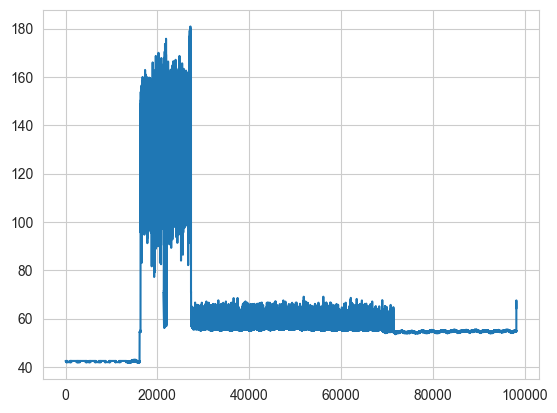

In [43]:
read_energy('./data/old/card_name_v100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_2/gpu0.log')
ax = plot_energy('./data/old/card_name_v100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_2/gpu0.log', 2)


In [ ]:
df2

In [ ]:
poi = ['INIT',
       'data head setup',
       'RunTFTCustomVersion A',
       'RunTFTCustomVersion bestfit Epoch:0',
       'RunTFTCustomVersion bestfit finalize',
       'DLprediction Iteration',
       'DLResults_Graphs timer_num:0',
       'RunTFTCustomVersion bestfit finalize VisualizeTFT event_num:0']

for i, row in df2.iterrows():
   label = row['timer']
   if label in poi:
      # print(row['timer'], row['start'])
      x = row['start']

      y = 180

      ax.text(x, y, label)
      ax.plot(x, y)
plt.show()